# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60.0K/60.0K [04:24<00:00, 227File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

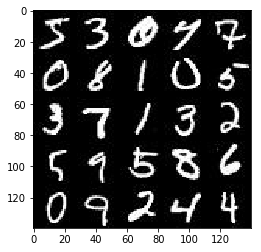

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

import helper
data_dir = './data'

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

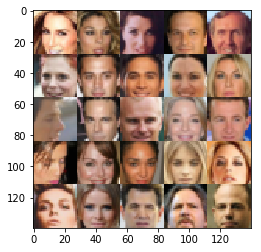

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0


c:\users\lai\anaconda3\envs\face_generation\lib\site-packages\ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, *(image_width, image_height, image_channels)), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z, tf.placeholder(tf.float32, [], name='learning_rate')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            # 16x16x64

            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 8x8x128

            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            flat = tf.reshape(relu3, (-1, 4*4*256))
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)

            return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`


Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
%matplotlib inline

import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
 
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
  
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

class GAN:
    def __init__(self, real_size, z_size, beta1=0.5):
        weight = real_size[1]
        height = real_size[2]
        channel = real_size[3]
        self.input_real, self.input_z, self.learning_rate = model_inputs(weight, height, channel, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              channel)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    steps = 0
    z_size = z_dim
    print_every=10
    show_every=100 
    samples, losses = [], []
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    net = GAN(data_shape, z_size, beta1=beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z, net.learning_rate:learning_rate})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images, net.learning_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs), "Discriminator Loss: {:.4f}...".format(train_loss_d), "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, net.input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0002... Generator Loss: 19.1699
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 2.1031
Epoch 1/2... Discriminator Loss: 0.6376... Generator Loss: 2.6704
Epoch 1/2... Discriminator Loss: 0.7995... Generator Loss: 2.4615
Epoch 1/2... Discriminator Loss: 1.0332... Generator Loss: 0.9784
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 2.7247
Epoch 1/2... Discriminator Loss: 3.5009... Generator Loss: 0.0574
Epoch 1/2... Discriminator Loss: 0.3666... Generator Loss: 1.9036


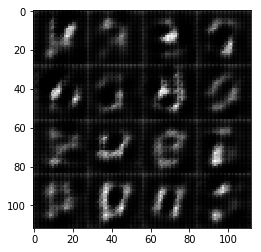

Epoch 1/2... Discriminator Loss: 0.5812... Generator Loss: 1.1569
Epoch 1/2... Discriminator Loss: 0.2716... Generator Loss: 1.7439
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 1.0277
Epoch 1/2... Discriminator Loss: 1.1957... Generator Loss: 0.9603
Epoch 1/2... Discriminator Loss: 0.8477... Generator Loss: 1.7961
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 4.1377
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 1.3431
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.7367... Generator Loss: 0.2550
Epoch 1/2... Discriminator Loss: 0.0585... Generator Loss: 3.8099


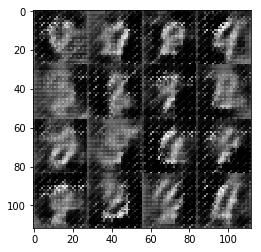

Epoch 1/2... Discriminator Loss: 0.0702... Generator Loss: 3.3150
Epoch 1/2... Discriminator Loss: 0.1399... Generator Loss: 3.0838
Epoch 1/2... Discriminator Loss: 0.0951... Generator Loss: 3.8831
Epoch 1/2... Discriminator Loss: 0.0122... Generator Loss: 5.8764
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 7.9354
Epoch 1/2... Discriminator Loss: 0.0366... Generator Loss: 5.6770
Epoch 1/2... Discriminator Loss: 0.2606... Generator Loss: 3.0992
Epoch 1/2... Discriminator Loss: 0.2312... Generator Loss: 3.6685
Epoch 1/2... Discriminator Loss: 0.0624... Generator Loss: 4.2790
Epoch 1/2... Discriminator Loss: 0.1072... Generator Loss: 3.7334


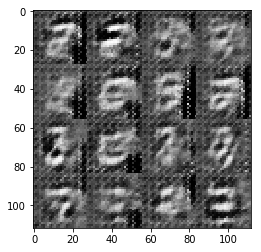

Epoch 1/2... Discriminator Loss: 0.0470... Generator Loss: 4.6426
Epoch 1/2... Discriminator Loss: 0.0207... Generator Loss: 6.4965
Epoch 1/2... Discriminator Loss: 0.0606... Generator Loss: 7.5883
Epoch 1/2... Discriminator Loss: 0.0155... Generator Loss: 8.4022
Epoch 1/2... Discriminator Loss: 0.0335... Generator Loss: 5.8148
Epoch 1/2... Discriminator Loss: 0.0426... Generator Loss: 10.5530
Epoch 1/2... Discriminator Loss: 0.1154... Generator Loss: 4.2903
Epoch 1/2... Discriminator Loss: 6.2202... Generator Loss: 13.3303
Epoch 1/2... Discriminator Loss: 1.5134... Generator Loss: 4.8473
Epoch 1/2... Discriminator Loss: 0.4849... Generator Loss: 2.0366


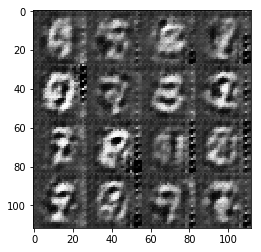

Epoch 1/2... Discriminator Loss: 0.6852... Generator Loss: 1.1634
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 3.4908... Generator Loss: 7.6999
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 2.7702
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 2.5139
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 0.9521... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 0.3831... Generator Loss: 1.4481


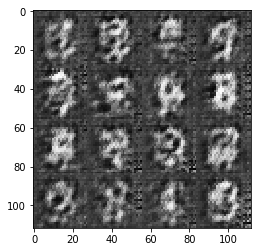

Epoch 1/2... Discriminator Loss: 0.6420... Generator Loss: 7.9266
Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 3.6514
Epoch 1/2... Discriminator Loss: 0.2268... Generator Loss: 2.1914
Epoch 1/2... Discriminator Loss: 0.0320... Generator Loss: 6.8124
Epoch 1/2... Discriminator Loss: 0.3335... Generator Loss: 2.1285
Epoch 1/2... Discriminator Loss: 0.9940... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.4954
Epoch 1/2... Discriminator Loss: 0.1493... Generator Loss: 2.5652
Epoch 1/2... Discriminator Loss: 0.5681... Generator Loss: 1.0955


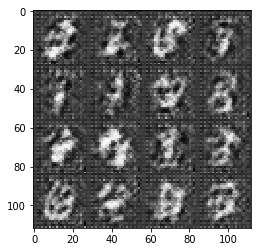

Epoch 1/2... Discriminator Loss: 0.0646... Generator Loss: 4.8369
Epoch 1/2... Discriminator Loss: 0.0535... Generator Loss: 4.9482
Epoch 1/2... Discriminator Loss: 0.0989... Generator Loss: 2.9867
Epoch 1/2... Discriminator Loss: 0.0738... Generator Loss: 3.0376
Epoch 1/2... Discriminator Loss: 0.0361... Generator Loss: 4.5564
Epoch 1/2... Discriminator Loss: 0.0278... Generator Loss: 7.2139
Epoch 1/2... Discriminator Loss: 0.1293... Generator Loss: 2.6365
Epoch 1/2... Discriminator Loss: 0.0158... Generator Loss: 6.0784
Epoch 1/2... Discriminator Loss: 0.0900... Generator Loss: 3.4257
Epoch 1/2... Discriminator Loss: 0.8328... Generator Loss: 1.2372


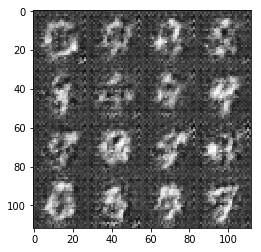

Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.0504
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 2.4590
Epoch 1/2... Discriminator Loss: 0.7179... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 0.6451... Generator Loss: 1.0663
Epoch 1/2... Discriminator Loss: 1.0603... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 0.1820... Generator Loss: 3.0193
Epoch 1/2... Discriminator Loss: 0.0977... Generator Loss: 3.1809
Epoch 1/2... Discriminator Loss: 0.2286... Generator Loss: 2.1581
Epoch 1/2... Discriminator Loss: 0.0618... Generator Loss: 3.4204
Epoch 1/2... Discriminator Loss: 4.6534... Generator Loss: 0.0149


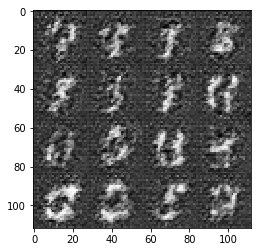

Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 1.3790
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 1.5830
Epoch 1/2... Discriminator Loss: 1.9818... Generator Loss: 0.2326
Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 2.2657
Epoch 1/2... Discriminator Loss: 0.8502... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 1.7638... Generator Loss: 0.2689
Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 0.7834
Epoch 1/2... Discriminator Loss: 0.0801... Generator Loss: 3.8069
Epoch 1/2... Discriminator Loss: 0.0648... Generator Loss: 4.0090


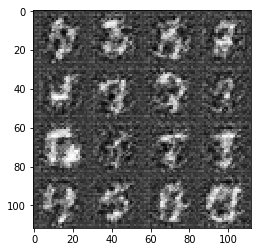

Epoch 1/2... Discriminator Loss: 0.0937... Generator Loss: 2.8397
Epoch 1/2... Discriminator Loss: 0.6289... Generator Loss: 0.9021
Epoch 1/2... Discriminator Loss: 0.0508... Generator Loss: 3.3474
Epoch 1/2... Discriminator Loss: 0.2890... Generator Loss: 1.7255
Epoch 1/2... Discriminator Loss: 0.0371... Generator Loss: 3.9311
Epoch 1/2... Discriminator Loss: 0.0431... Generator Loss: 4.1650
Epoch 1/2... Discriminator Loss: 0.0198... Generator Loss: 5.7033
Epoch 1/2... Discriminator Loss: 0.0358... Generator Loss: 4.1997
Epoch 1/2... Discriminator Loss: 0.0043... Generator Loss: 7.3819
Epoch 1/2... Discriminator Loss: 0.1355... Generator Loss: 2.4418


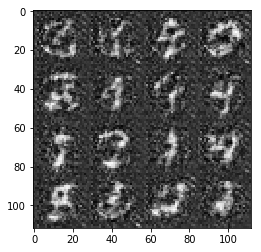

Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 5.8176
Epoch 1/2... Discriminator Loss: 0.1704... Generator Loss: 2.1822
Epoch 1/2... Discriminator Loss: 0.0358... Generator Loss: 3.9566
Epoch 1/2... Discriminator Loss: 0.0067... Generator Loss: 6.1080
Epoch 1/2... Discriminator Loss: 0.0057... Generator Loss: 6.5540
Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 7.5627
Epoch 1/2... Discriminator Loss: 1.2837... Generator Loss: 5.5564
Epoch 1/2... Discriminator Loss: 2.3672... Generator Loss: 0.1895
Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 2.1980
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 3.0322


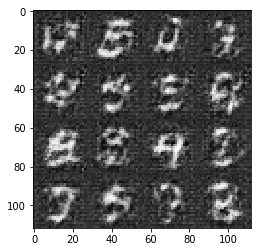

Epoch 1/2... Discriminator Loss: 0.3991... Generator Loss: 2.0830
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.1411
Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 3.2878
Epoch 1/2... Discriminator Loss: 0.7227... Generator Loss: 3.3974
Epoch 1/2... Discriminator Loss: 0.4133... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.1450
Epoch 1/2... Discriminator Loss: 0.7164... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 0.6601... Generator Loss: 0.9299
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 1.3606
Epoch 1/2... Discriminator Loss: 0.1231... Generator Loss: 2.5354


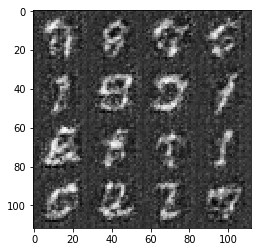

Epoch 2/2... Discriminator Loss: 0.2063... Generator Loss: 1.9518
Epoch 2/2... Discriminator Loss: 0.4085... Generator Loss: 1.3312
Epoch 2/2... Discriminator Loss: 0.2752... Generator Loss: 1.7330
Epoch 2/2... Discriminator Loss: 0.1170... Generator Loss: 2.8092
Epoch 2/2... Discriminator Loss: 0.0135... Generator Loss: 5.7469
Epoch 2/2... Discriminator Loss: 0.0093... Generator Loss: 6.1647
Epoch 2/2... Discriminator Loss: 0.0962... Generator Loss: 2.8284
Epoch 2/2... Discriminator Loss: 0.2386... Generator Loss: 1.8456
Epoch 2/2... Discriminator Loss: 0.0174... Generator Loss: 4.9129
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 5.4360


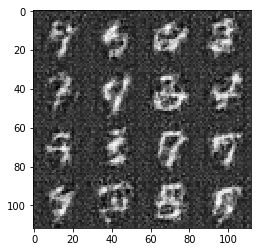

Epoch 2/2... Discriminator Loss: 0.1254... Generator Loss: 2.4097
Epoch 2/2... Discriminator Loss: 0.0267... Generator Loss: 4.2725
Epoch 2/2... Discriminator Loss: 0.0350... Generator Loss: 3.9931
Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 4.4255
Epoch 2/2... Discriminator Loss: 0.0107... Generator Loss: 4.9267
Epoch 2/2... Discriminator Loss: 0.0739... Generator Loss: 3.0148
Epoch 2/2... Discriminator Loss: 0.0366... Generator Loss: 4.1145
Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 6.3487
Epoch 2/2... Discriminator Loss: 0.0096... Generator Loss: 5.2107
Epoch 2/2... Discriminator Loss: 0.0077... Generator Loss: 6.3012


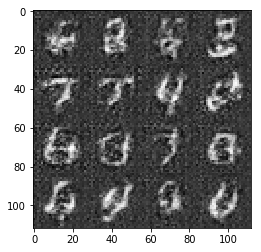

Epoch 2/2... Discriminator Loss: 0.0155... Generator Loss: 4.6864
Epoch 2/2... Discriminator Loss: 0.0536... Generator Loss: 3.2640
Epoch 2/2... Discriminator Loss: 0.0788... Generator Loss: 3.0800
Epoch 2/2... Discriminator Loss: 0.0453... Generator Loss: 3.5605
Epoch 2/2... Discriminator Loss: 0.0127... Generator Loss: 4.8766
Epoch 2/2... Discriminator Loss: 0.0051... Generator Loss: 6.5500
Epoch 2/2... Discriminator Loss: 0.0064... Generator Loss: 6.0532
Epoch 2/2... Discriminator Loss: 0.0199... Generator Loss: 4.7660
Epoch 2/2... Discriminator Loss: 0.0072... Generator Loss: 6.4960
Epoch 2/2... Discriminator Loss: 0.0057... Generator Loss: 5.7938


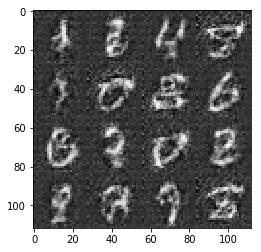

Epoch 2/2... Discriminator Loss: 0.0057... Generator Loss: 6.1074
Epoch 2/2... Discriminator Loss: 0.0627... Generator Loss: 3.1071
Epoch 2/2... Discriminator Loss: 0.0081... Generator Loss: 5.6282
Epoch 2/2... Discriminator Loss: 0.0105... Generator Loss: 5.3455
Epoch 2/2... Discriminator Loss: 1.4841... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.1508
Epoch 2/2... Discriminator Loss: 0.7667... Generator Loss: 0.9500
Epoch 2/2... Discriminator Loss: 0.5325... Generator Loss: 2.5088
Epoch 2/2... Discriminator Loss: 0.5073... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 0.5290... Generator Loss: 2.4935


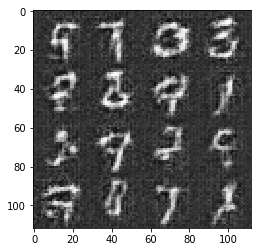

Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 0.3873... Generator Loss: 2.4182
Epoch 2/2... Discriminator Loss: 0.4926... Generator Loss: 2.4128
Epoch 2/2... Discriminator Loss: 1.6183... Generator Loss: 6.8502
Epoch 2/2... Discriminator Loss: 0.2454... Generator Loss: 2.0628
Epoch 2/2... Discriminator Loss: 0.2141... Generator Loss: 2.1193
Epoch 2/2... Discriminator Loss: 0.0921... Generator Loss: 4.5934
Epoch 2/2... Discriminator Loss: 0.2111... Generator Loss: 2.5307
Epoch 2/2... Discriminator Loss: 0.0640... Generator Loss: 3.6529
Epoch 2/2... Discriminator Loss: 0.0780... Generator Loss: 3.5395


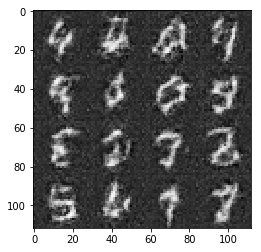

Epoch 2/2... Discriminator Loss: 0.0467... Generator Loss: 3.9934
Epoch 2/2... Discriminator Loss: 0.0990... Generator Loss: 2.6832
Epoch 2/2... Discriminator Loss: 0.1364... Generator Loss: 2.3553
Epoch 2/2... Discriminator Loss: 0.0178... Generator Loss: 4.7309
Epoch 2/2... Discriminator Loss: 0.0462... Generator Loss: 3.7229
Epoch 2/2... Discriminator Loss: 0.1059... Generator Loss: 2.7781
Epoch 2/2... Discriminator Loss: 0.1616... Generator Loss: 2.2915
Epoch 2/2... Discriminator Loss: 0.0914... Generator Loss: 2.8414
Epoch 2/2... Discriminator Loss: 0.0382... Generator Loss: 3.8196
Epoch 2/2... Discriminator Loss: 0.0169... Generator Loss: 5.1811


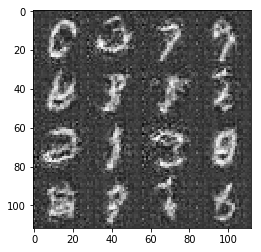

Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 5.4285
Epoch 2/2... Discriminator Loss: 0.0188... Generator Loss: 4.6523
Epoch 2/2... Discriminator Loss: 0.0158... Generator Loss: 4.8592
Epoch 2/2... Discriminator Loss: 0.0027... Generator Loss: 6.8164
Epoch 2/2... Discriminator Loss: 0.0830... Generator Loss: 3.0042
Epoch 2/2... Discriminator Loss: 0.0131... Generator Loss: 5.3202
Epoch 2/2... Discriminator Loss: 0.0588... Generator Loss: 3.3038
Epoch 2/2... Discriminator Loss: 0.0068... Generator Loss: 6.7396
Epoch 2/2... Discriminator Loss: 0.0068... Generator Loss: 5.8482
Epoch 2/2... Discriminator Loss: 0.0342... Generator Loss: 3.9625


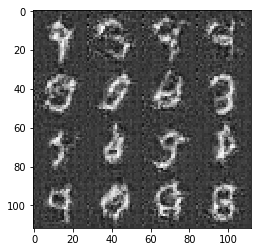

Epoch 2/2... Discriminator Loss: 0.0059... Generator Loss: 5.9793
Epoch 2/2... Discriminator Loss: 0.0033... Generator Loss: 6.3838
Epoch 2/2... Discriminator Loss: 0.0022... Generator Loss: 6.8899
Epoch 2/2... Discriminator Loss: 0.0190... Generator Loss: 4.4466
Epoch 2/2... Discriminator Loss: 0.0064... Generator Loss: 5.7377
Epoch 2/2... Discriminator Loss: 0.0053... Generator Loss: 6.4548
Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 6.3709
Epoch 2/2... Discriminator Loss: 0.0090... Generator Loss: 6.0501
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 1.7257
Epoch 2/2... Discriminator Loss: 1.0015... Generator Loss: 0.7288


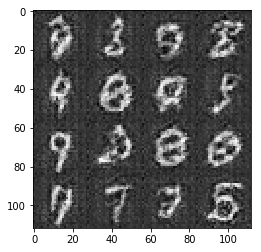

Epoch 2/2... Discriminator Loss: 0.9390... Generator Loss: 0.8727
Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 2.5705
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 0.4719... Generator Loss: 1.7171
Epoch 2/2... Discriminator Loss: 0.4559... Generator Loss: 1.8287
Epoch 2/2... Discriminator Loss: 0.4717... Generator Loss: 1.4812
Epoch 2/2... Discriminator Loss: 0.6019... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.8586
Epoch 2/2... Discriminator Loss: 0.4602... Generator Loss: 1.4656
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.3731


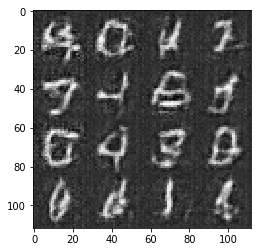

Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 4.4959
Epoch 2/2... Discriminator Loss: 0.3902... Generator Loss: 2.3637
Epoch 2/2... Discriminator Loss: 0.5980... Generator Loss: 3.7701
Epoch 2/2... Discriminator Loss: 0.2800... Generator Loss: 2.0590
Epoch 2/2... Discriminator Loss: 0.3554... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 1.8700... Generator Loss: 6.2760
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 2.5648
Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 2.1161
Epoch 2/2... Discriminator Loss: 0.3544... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 0.2404... Generator Loss: 2.2970


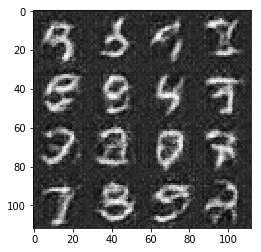

Epoch 2/2... Discriminator Loss: 0.2396... Generator Loss: 2.3260
Epoch 2/2... Discriminator Loss: 0.3194... Generator Loss: 1.5873
Epoch 2/2... Discriminator Loss: 0.4707... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 0.2793... Generator Loss: 1.7928
Epoch 2/2... Discriminator Loss: 0.2053... Generator Loss: 2.2490
Epoch 2/2... Discriminator Loss: 0.7350... Generator Loss: 0.9509
Epoch 2/2... Discriminator Loss: 0.1854... Generator Loss: 2.3133
Epoch 2/2... Discriminator Loss: 0.1925... Generator Loss: 2.2122
Epoch 2/2... Discriminator Loss: 0.3425... Generator Loss: 1.4904
Epoch 2/2... Discriminator Loss: 0.1899... Generator Loss: 2.2780


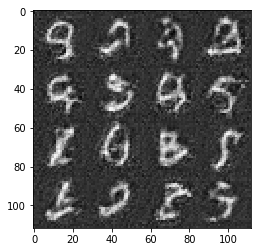

Epoch 2/2... Discriminator Loss: 0.0874... Generator Loss: 3.0747
Epoch 2/2... Discriminator Loss: 0.2685... Generator Loss: 1.9028
Epoch 2/2... Discriminator Loss: 0.0678... Generator Loss: 4.8311
Epoch 2/2... Discriminator Loss: 0.2040... Generator Loss: 2.0359
Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 2.8223
Epoch 2/2... Discriminator Loss: 0.0473... Generator Loss: 3.6365
Epoch 2/2... Discriminator Loss: 0.0317... Generator Loss: 4.4696
Epoch 2/2... Discriminator Loss: 0.0434... Generator Loss: 3.8141
Epoch 2/2... Discriminator Loss: 1.8936... Generator Loss: 2.9134
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.2939


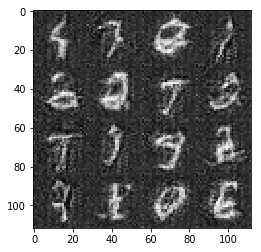

In [31]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0008... Generator Loss: 11.3328
Epoch 1/1... Discriminator Loss: 0.2902... Generator Loss: 23.7364
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 4.3164
Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 0.5351... Generator Loss: 1.3558
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 2.9456
Epoch 1/1... Discriminator Loss: 0.2666... Generator Loss: 2.0271
Epoch 1/1... Discriminator Loss: 0.0098... Generator Loss: 5.9994
Epoch 1/1... Discriminator Loss: 0.0093... Generator Loss: 5.5194


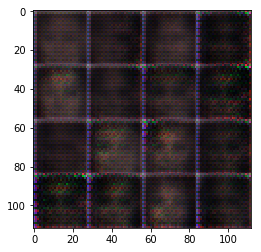

Epoch 1/1... Discriminator Loss: 0.0129... Generator Loss: 5.9506
Epoch 1/1... Discriminator Loss: 0.0230... Generator Loss: 4.2792
Epoch 1/1... Discriminator Loss: 0.0333... Generator Loss: 4.0244
Epoch 1/1... Discriminator Loss: 0.0177... Generator Loss: 4.8092
Epoch 1/1... Discriminator Loss: 4.7125... Generator Loss: 0.0282
Epoch 1/1... Discriminator Loss: 0.2288... Generator Loss: 6.2022
Epoch 1/1... Discriminator Loss: 0.1172... Generator Loss: 3.0885
Epoch 1/1... Discriminator Loss: 0.0115... Generator Loss: 5.9863
Epoch 1/1... Discriminator Loss: 2.6396... Generator Loss: 0.0858
Epoch 1/1... Discriminator Loss: 0.0180... Generator Loss: 5.2028


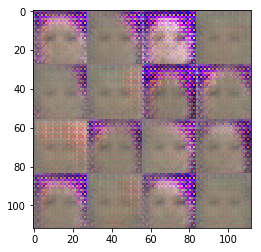

Epoch 1/1... Discriminator Loss: 0.5762... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 4.2891
Epoch 1/1... Discriminator Loss: 0.2707... Generator Loss: 2.4197
Epoch 1/1... Discriminator Loss: 0.0622... Generator Loss: 3.8804
Epoch 1/1... Discriminator Loss: 0.0545... Generator Loss: 4.0601
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.7968
Epoch 1/1... Discriminator Loss: 0.0429... Generator Loss: 4.2778
Epoch 1/1... Discriminator Loss: 9.3964... Generator Loss: 8.5022
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 2.2274


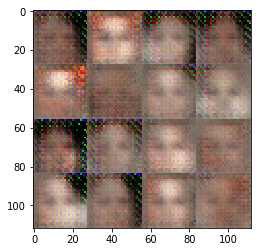

Epoch 1/1... Discriminator Loss: 0.1366... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 0.1496... Generator Loss: 5.0418
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.5202
Epoch 1/1... Discriminator Loss: 0.0466... Generator Loss: 4.3846
Epoch 1/1... Discriminator Loss: 0.0662... Generator Loss: 3.5653
Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.7120
Epoch 1/1... Discriminator Loss: 4.6662... Generator Loss: 3.9570
Epoch 1/1... Discriminator Loss: 3.1179... Generator Loss: 4.7707
Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 2.1048
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 1.0063


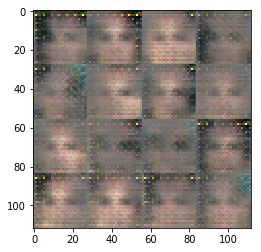

Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 0.0926... Generator Loss: 3.2681
Epoch 1/1... Discriminator Loss: 0.1280... Generator Loss: 2.6677
Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 1.3776
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 0.9903
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.2177
Epoch 1/1... Discriminator Loss: 0.0182... Generator Loss: 5.6928
Epoch 1/1... Discriminator Loss: 3.0481... Generator Loss: 1.7773
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.8600


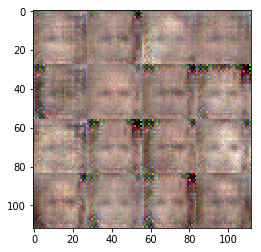

Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 0.9259
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.6466
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 1.1279
Epoch 1/1... Discriminator Loss: 0.9024... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 1.0778
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 1.4700
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.7817


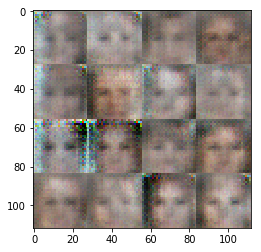

Epoch 1/1... Discriminator Loss: 1.0892... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 0.4694... Generator Loss: 2.4247
Epoch 1/1... Discriminator Loss: 0.0748... Generator Loss: 5.0234
Epoch 1/1... Discriminator Loss: 0.1681... Generator Loss: 4.3712
Epoch 1/1... Discriminator Loss: 1.6247... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.0296
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.8773
Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 3.1904
Epoch 1/1... Discriminator Loss: 1.6950... Generator Loss: 2.9796


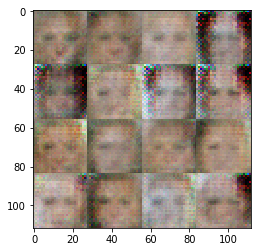

Epoch 1/1... Discriminator Loss: 0.1013... Generator Loss: 4.1443
Epoch 1/1... Discriminator Loss: 2.2835... Generator Loss: 0.3732
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 0.3352... Generator Loss: 2.7589
Epoch 1/1... Discriminator Loss: 0.2635... Generator Loss: 2.2994
Epoch 1/1... Discriminator Loss: 0.0502... Generator Loss: 5.4361
Epoch 1/1... Discriminator Loss: 0.3152... Generator Loss: 4.4523
Epoch 1/1... Discriminator Loss: 0.0434... Generator Loss: 3.6663
Epoch 1/1... Discriminator Loss: 0.1737... Generator Loss: 2.2468


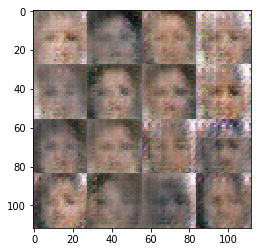

Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 4.9866
Epoch 1/1... Discriminator Loss: 0.0216... Generator Loss: 6.7072
Epoch 1/1... Discriminator Loss: 0.0672... Generator Loss: 3.5634
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.7536
Epoch 1/1... Discriminator Loss: 0.0450... Generator Loss: 5.0255
Epoch 1/1... Discriminator Loss: 0.0661... Generator Loss: 3.6989
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 7.6253
Epoch 1/1... Discriminator Loss: 0.0040... Generator Loss: 7.4314
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.9422
Epoch 1/1... Discriminator Loss: 3.5373... Generator Loss: 0.2547


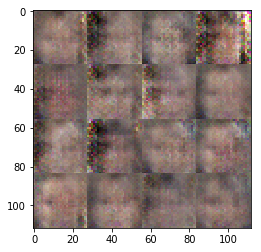

Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 3.6834
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.4689
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 4.1948
Epoch 1/1... Discriminator Loss: 0.1711... Generator Loss: 3.7817
Epoch 1/1... Discriminator Loss: 0.1253... Generator Loss: 7.5452
Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 3.1699
Epoch 1/1... Discriminator Loss: 0.0549... Generator Loss: 3.2539


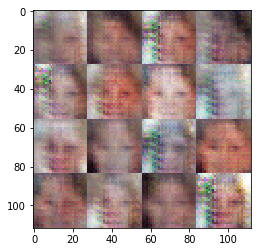

Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 3.1529
Epoch 1/1... Discriminator Loss: 0.0539... Generator Loss: 9.5870
Epoch 1/1... Discriminator Loss: 0.0084... Generator Loss: 5.5900
Epoch 1/1... Discriminator Loss: 0.0068... Generator Loss: 6.1647
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 0.4054... Generator Loss: 2.4464
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 0.1897... Generator Loss: 2.4689
Epoch 1/1... Discriminator Loss: 2.1956... Generator Loss: 0.2790
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 1.2835


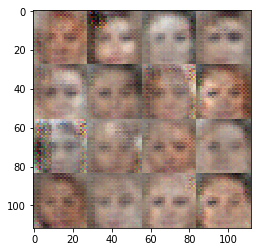

Epoch 1/1... Discriminator Loss: 0.1210... Generator Loss: 3.7704
Epoch 1/1... Discriminator Loss: 0.6895... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.0168... Generator Loss: 4.6775
Epoch 1/1... Discriminator Loss: 0.2896... Generator Loss: 1.8365
Epoch 1/1... Discriminator Loss: 0.4943... Generator Loss: 1.2299
Epoch 1/1... Discriminator Loss: 0.1009... Generator Loss: 2.8282
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 3.8152
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 3.7106
Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 3.3789


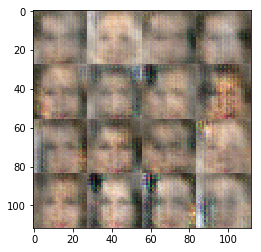

Epoch 1/1... Discriminator Loss: 2.1701... Generator Loss: 0.1715
Epoch 1/1... Discriminator Loss: 0.1133... Generator Loss: 2.8820
Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 2.2208
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 1.7600
Epoch 1/1... Discriminator Loss: 0.0445... Generator Loss: 3.6194
Epoch 1/1... Discriminator Loss: 3.0634... Generator Loss: 0.0566
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 1.3387
Epoch 1/1... Discriminator Loss: 0.3177... Generator Loss: 1.5754
Epoch 1/1... Discriminator Loss: 0.0155... Generator Loss: 5.8272
Epoch 1/1... Discriminator Loss: 0.0947... Generator Loss: 2.6448


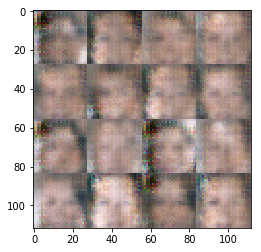

Epoch 1/1... Discriminator Loss: 0.0417... Generator Loss: 4.8111
Epoch 1/1... Discriminator Loss: 0.0633... Generator Loss: 4.0180
Epoch 1/1... Discriminator Loss: 0.0861... Generator Loss: 4.9730
Epoch 1/1... Discriminator Loss: 0.0044... Generator Loss: 7.2893
Epoch 1/1... Discriminator Loss: 0.0110... Generator Loss: 5.0843
Epoch 1/1... Discriminator Loss: 0.0674... Generator Loss: 3.3768
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.2333
Epoch 1/1... Discriminator Loss: 0.0542... Generator Loss: 3.8525
Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 0.4120
Epoch 1/1... Discriminator Loss: 1.2478... Generator Loss: 0.7266


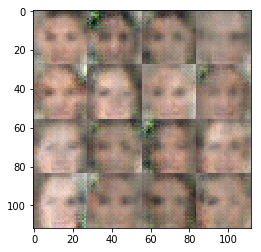

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.2038... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.3088
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.4321
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.4323
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 1.1090


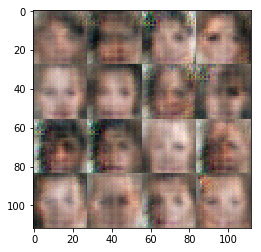

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.6630... Generator Loss: 3.9676
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 0.1756... Generator Loss: 2.8681
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 1.3389
Epoch 1/1... Discriminator Loss: 2.2461... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 3.6565
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.2050... Generator Loss: 1.8173
Epoch 1/1... Discriminator Loss: 0.0609... Generator Loss: 4.0925


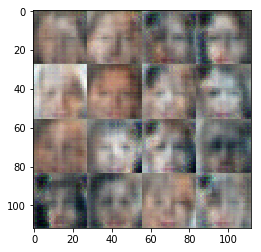

Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 3.9688
Epoch 1/1... Discriminator Loss: 0.0081... Generator Loss: 8.0177
Epoch 1/1... Discriminator Loss: 0.0122... Generator Loss: 4.9441
Epoch 1/1... Discriminator Loss: 0.0013... Generator Loss: 8.9946
Epoch 1/1... Discriminator Loss: 0.0024... Generator Loss: 6.9379
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 3.4121
Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 5.6378
Epoch 1/1... Discriminator Loss: 0.0831... Generator Loss: 2.8391
Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 4.0588


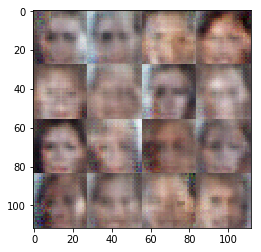

Epoch 1/1... Discriminator Loss: 0.0193... Generator Loss: 4.9078
Epoch 1/1... Discriminator Loss: 0.0106... Generator Loss: 6.2698
Epoch 1/1... Discriminator Loss: 0.0059... Generator Loss: 9.4839
Epoch 1/1... Discriminator Loss: 0.0149... Generator Loss: 9.3052
Epoch 1/1... Discriminator Loss: 0.0014... Generator Loss: 7.3384
Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 5.3747
Epoch 1/1... Discriminator Loss: 0.0029... Generator Loss: 7.0396
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 1.5642
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 1.3240
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9408


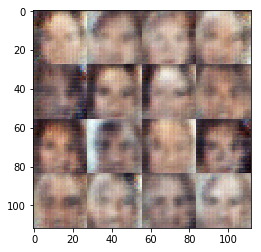

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.4185
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7330


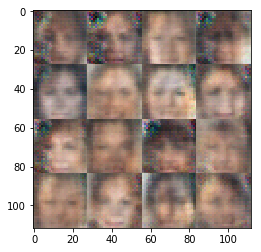

Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 1.0105
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 1.0970
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.0600... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.5988
Epoch 1/1... Discriminator Loss: 0.9862... Generator Loss: 1.1214


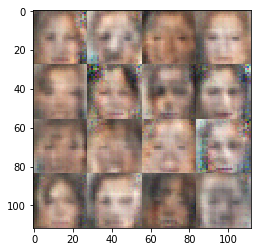

Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.8919
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.5012
Epoch 1/1... Discriminator Loss: 0.8412... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 0.8442
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 1.3894
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.9907... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.6986


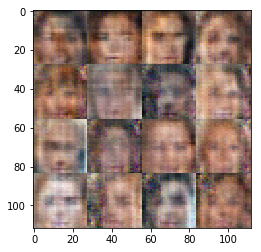

Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.8996
Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2527
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.4326
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 1.6001
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.4877
Epoch 1/1... Discriminator Loss: 1.5875... Generator Loss: 0.3076


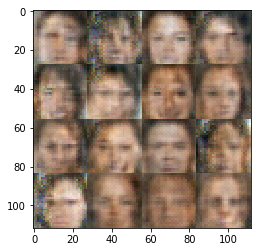

Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.6244
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.8662... Generator Loss: 0.2519
Epoch 1/1... Discriminator Loss: 0.5623... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.3414


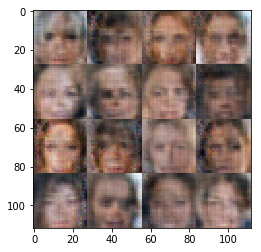

Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 1.9141
Epoch 1/1... Discriminator Loss: 1.6603... Generator Loss: 2.7415
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.8044
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 0.6352... Generator Loss: 2.0537
Epoch 1/1... Discriminator Loss: 2.4348... Generator Loss: 5.6292
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.8728


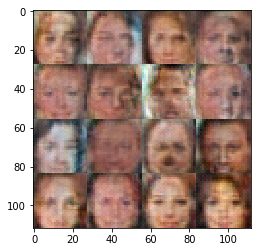

Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 0.2110
Epoch 1/1... Discriminator Loss: 2.2231... Generator Loss: 0.1587
Epoch 1/1... Discriminator Loss: 0.6699... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 2.4987
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 1.3751


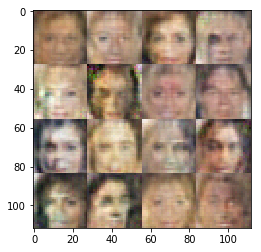

Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.9776
Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.7161... Generator Loss: 1.6720
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 2.2767... Generator Loss: 0.1386


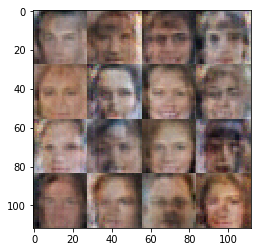

Epoch 1/1... Discriminator Loss: 1.9676... Generator Loss: 3.5723
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 1.9727
Epoch 1/1... Discriminator Loss: 1.1637... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 0.5923... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.6415... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.1096... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 0.8258


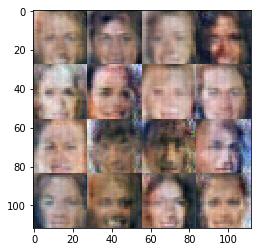

Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.1421
Epoch 1/1... Discriminator Loss: 2.8908... Generator Loss: 0.0738
Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 0.8437
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5461
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 3.2830... Generator Loss: 3.2344


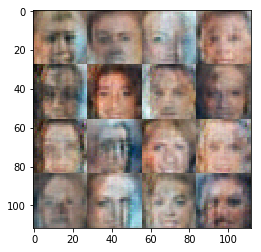

Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 0.6518... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 3.4000
Epoch 1/1... Discriminator Loss: 2.1641... Generator Loss: 1.7582
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 2.5587... Generator Loss: 0.0991
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 2.0512... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.3374


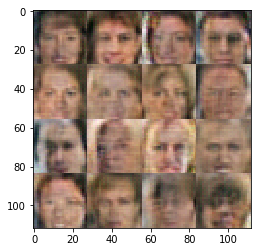

Epoch 1/1... Discriminator Loss: 1.8219... Generator Loss: 0.2671
Epoch 1/1... Discriminator Loss: 1.7207... Generator Loss: 0.2925
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.8651
Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.8135... Generator Loss: 1.5373
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.6198


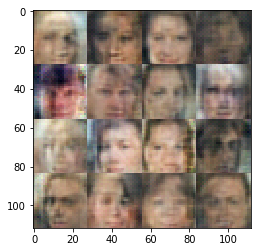

Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 0.5411... Generator Loss: 1.4922
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 1.5371... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 0.8803... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 1.8334
Epoch 1/1... Discriminator Loss: 1.4851... Generator Loss: 0.3907


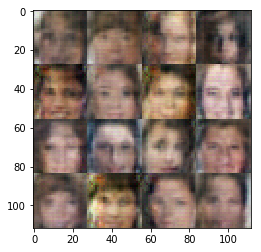

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.1031
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.0525
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.1079
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.0650... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.4686
Epoch 1/1... Discriminator Loss: 0.3627... Generator Loss: 1.6943


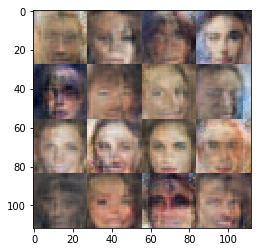

Epoch 1/1... Discriminator Loss: 0.5840... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 1.3332
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.6144... Generator Loss: 0.9580
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.8427


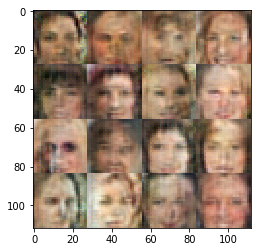

Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 1.6367
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.4310
Epoch 1/1... Discriminator Loss: 0.4145... Generator Loss: 2.2948
Epoch 1/1... Discriminator Loss: 2.2012... Generator Loss: 1.2149


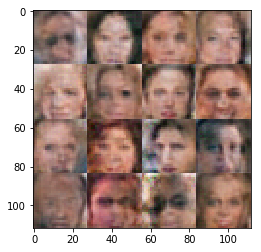

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.4384... Generator Loss: 1.3621
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.3658
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.7552
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 1.1799


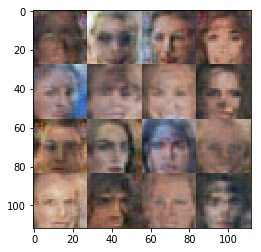

Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 0.7276... Generator Loss: 1.3527
Epoch 1/1... Discriminator Loss: 0.6598... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.7145... Generator Loss: 2.1784
Epoch 1/1... Discriminator Loss: 1.9627... Generator Loss: 0.1779
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.3814
Epoch 1/1... Discriminator Loss: 1.0554... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 1.3095


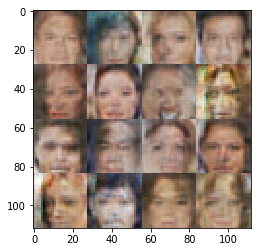

Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 3.4376
Epoch 1/1... Discriminator Loss: 0.4619... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 0.2964... Generator Loss: 1.6464
Epoch 1/1... Discriminator Loss: 1.7349... Generator Loss: 0.2775
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 1.0655
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.5233
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0594


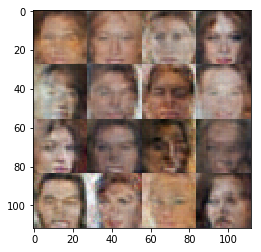

Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 2.3345... Generator Loss: 0.1732
Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.6956
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 0.5702
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.6405
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 0.9370... Generator Loss: 0.7001


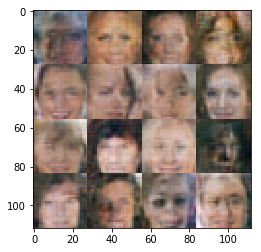

Epoch 1/1... Discriminator Loss: 0.2812... Generator Loss: 1.9473
Epoch 1/1... Discriminator Loss: 0.3687... Generator Loss: 1.5161
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 1.6015
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 0.3900... Generator Loss: 1.4546
Epoch 1/1... Discriminator Loss: 5.4018... Generator Loss: 6.2230
Epoch 1/1... Discriminator Loss: 0.7061... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 1.7414
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 2.0227


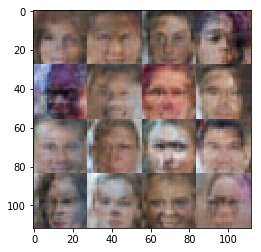

Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.5880... Generator Loss: 0.2985
Epoch 1/1... Discriminator Loss: 1.6733... Generator Loss: 0.2664
Epoch 1/1... Discriminator Loss: 0.3072... Generator Loss: 1.8919
Epoch 1/1... Discriminator Loss: 0.2032... Generator Loss: 2.6551
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5852
Epoch 1/1... Discriminator Loss: 0.8220... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.0905


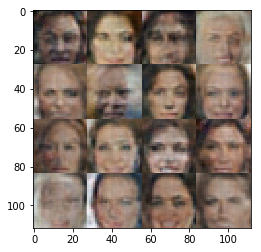

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 0.2846... Generator Loss: 2.0499
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 0.3220... Generator Loss: 1.9041
Epoch 1/1... Discriminator Loss: 0.6113... Generator Loss: 0.9624


In [35]:
batch_size = 50
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.